In [1]:
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import sklearn
%matplotlib inline

C:\Users\joshspeagle\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\joshspeagle\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\joshspeagle\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\joshspeagle\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

In [3]:
# import GP regressor and associated kernels
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [4]:
# initialize random number seed, so that results are replicable
random_seed = 7876  # this is "SURP" on the number pad (can be changed)
np.random.seed(random_seed)

In [5]:
# define our Gaussian Process
sigma, scale = 1., 1. 
kernel = ConstantKernel(constant_value=sigma**2) * RBF(length_scale=scale)
gp = GaussianProcessRegressor(kernel=kernel)

In [6]:
ngrid, edge = 21, 2.5
xgrid, ygrid, zgrid = [np.linspace(-edge, edge, ngrid) for i in range(3)]
Xgrid = np.array([[x, y, z] for x in xgrid for y in ygrid for z in zgrid])
print(np.shape(Xgrid))

(9261, 3)


In [7]:
Ygrid_mean, Ygrid_cov = gp.predict(Xgrid, return_cov=True)
print(np.shape(Ygrid_mean), np.shape(Ygrid_cov))

(9261,) (9261, 9261)


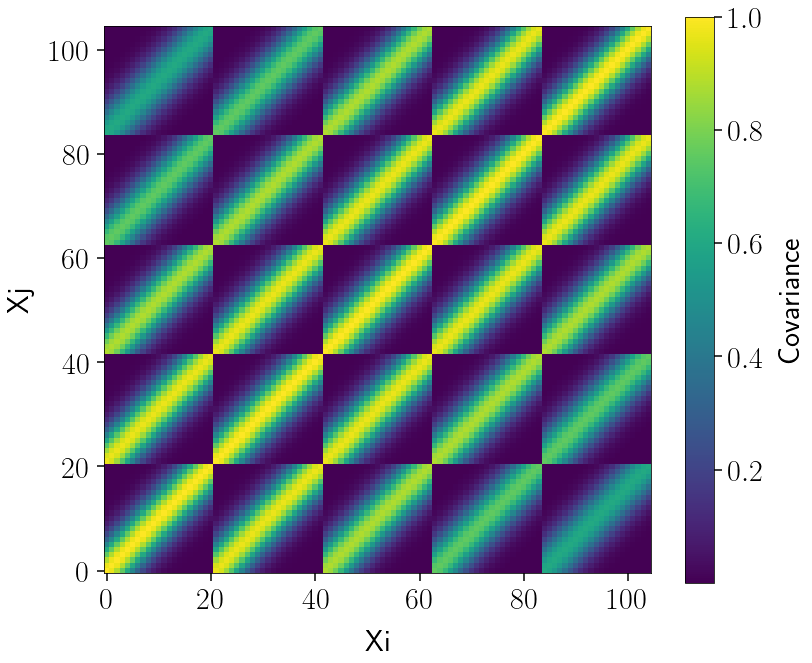

In [8]:
# this is a 100 x 100 grid of the covariance matrix of each (x,y,z) with each other
# the banded structure is because every ngrid points, we have looped through one of x, y, or z
# the different shading is because closer points have higher covariance
plt.figure(figsize=(12, 10))
plt.imshow(Ygrid_cov[:ngrid*5,:ngrid*5], origin='lower')
plt.colorbar(label='Covariance')
plt.xlabel('Xi')
plt.ylabel('Xj')
plt.tight_layout()

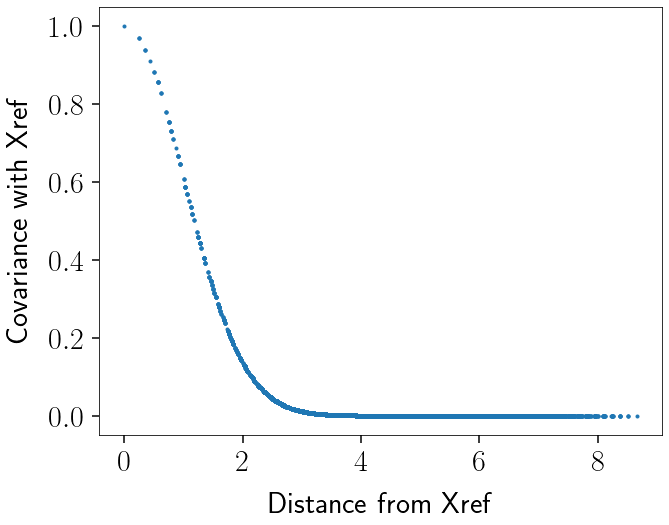

In [9]:
# convert all positions to be relative to some reference point
idx = 0  # define index
Xref = Xgrid[idx]  # get reference point
Rref = np.sqrt(np.sum((Xgrid - Xref)**2, axis=1))  # define distance to reference point

plt.figure(figsize=(10, 8))
plt.plot(Rref, Ygrid_cov[:, idx], '.')
plt.xlabel('Distance from Xref')
plt.ylabel('Covariance with Xref')
plt.tight_layout()

In [10]:
Ygrid_samps = gp.sample_y(Xgrid).reshape(len(Xgrid))

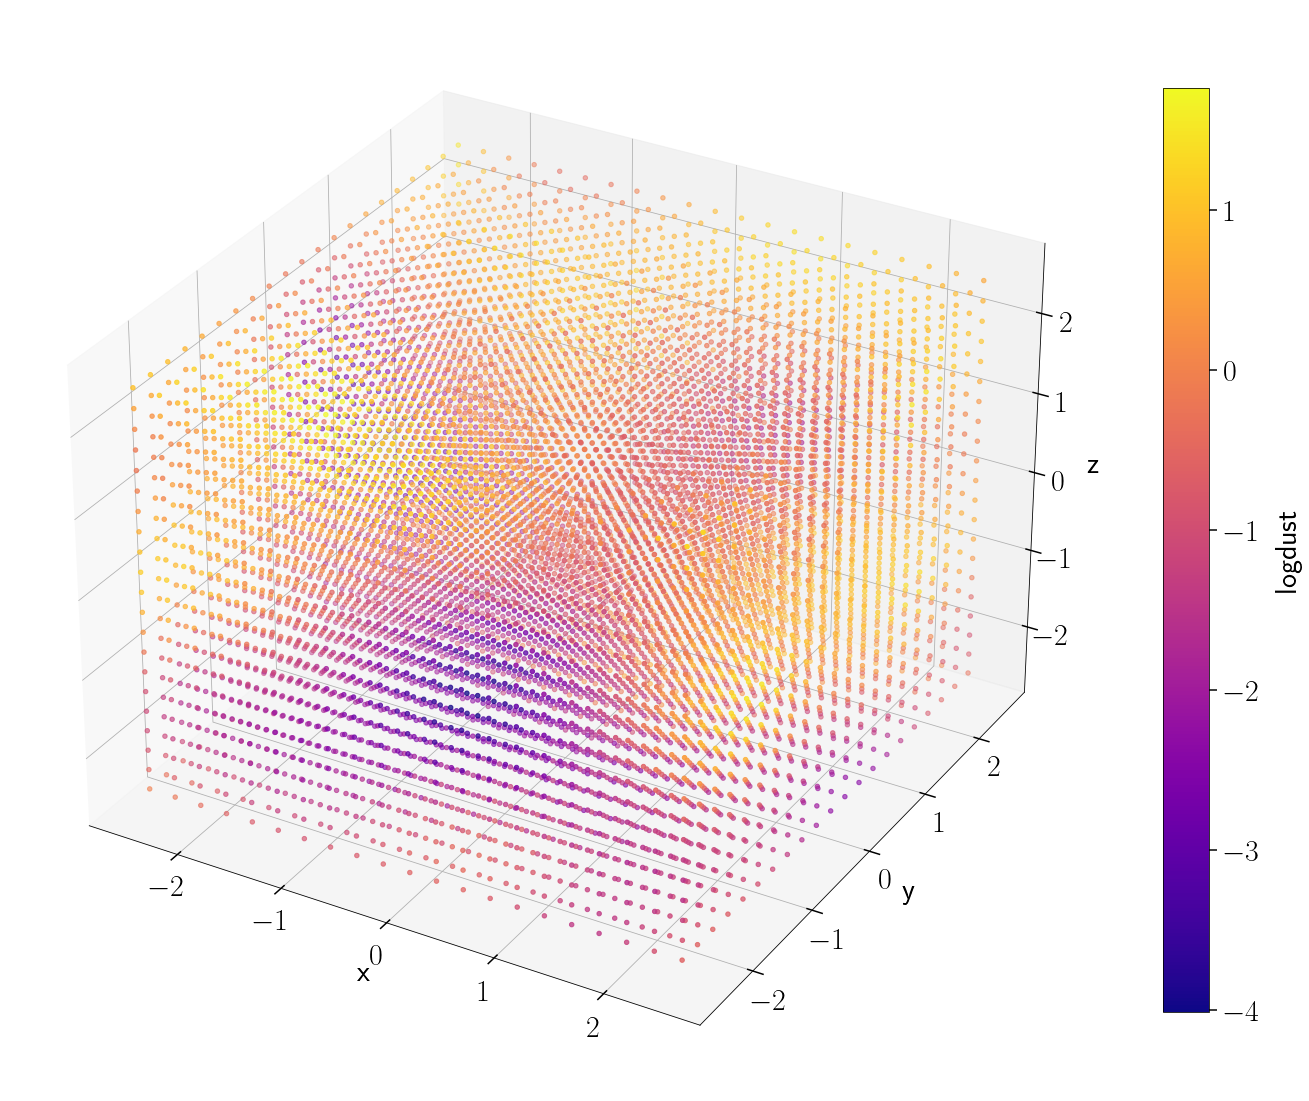

In [11]:
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(Xgrid[:, 0], Xgrid[:, 1], Xgrid[:, 2], c=Ygrid_samps, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.85)
cbar.set_label('logdust')
plt.tight_layout()

In [12]:
from scipy import interpolate
logdust = interpolate.Rbf(Xgrid[:, 0], Xgrid[:, 1], Xgrid[:, 2], Ygrid_samps, 
                          function='thin_plate',  # specific interpolation method
                          smooth=0)  # smoothing parameter (0=exact fit)

In [13]:
# simulate stars
n_stars = 10000  # with more stars, our model should get better

X = np.random.uniform(-edge, edge, size=(n_stars, 3))  # true positions

# evaluate positions over our log-dust density field
Y = logdust(X[:, 0], X[:, 1], X[:, 2])  # intrinsic values

# training/validation/testing splits
f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

# split data
X_train, X_valid, X_test = X[:idx_train], X[idx_train:idx_valid], X[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]

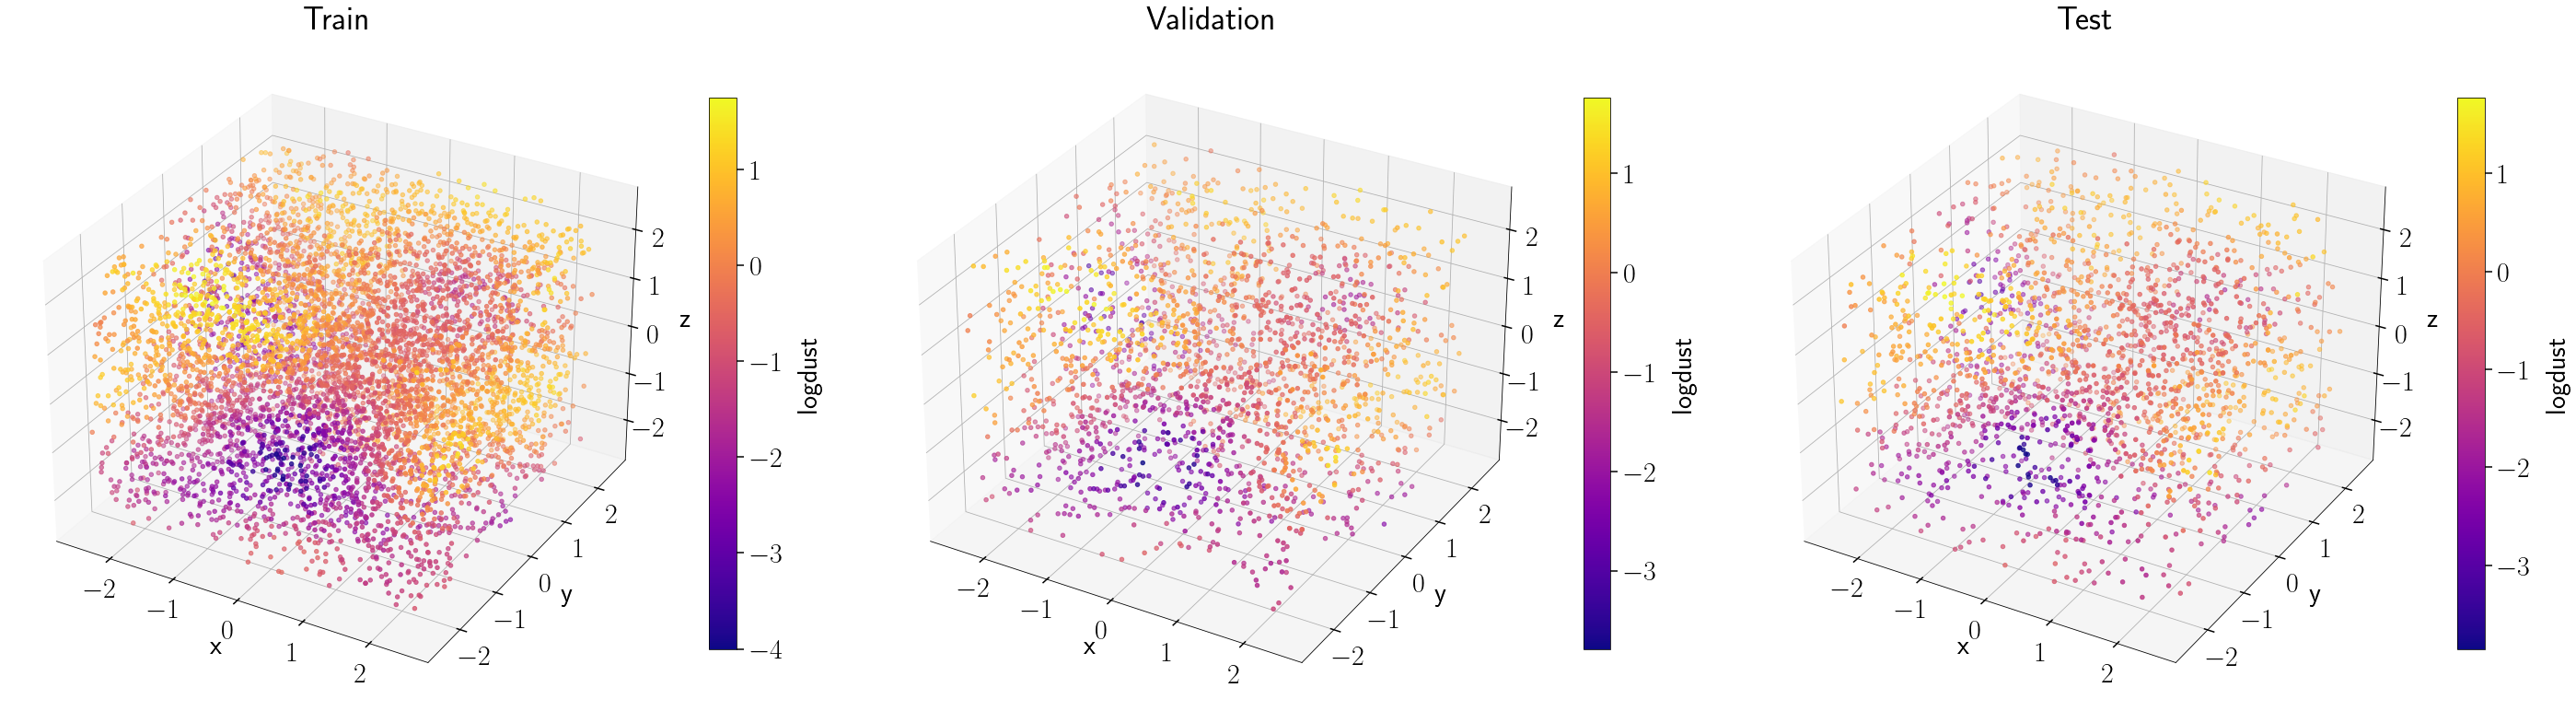

In [14]:
fig = plt.figure(figsize=(40, 12))

ax = fig.add_subplot(131, projection='3d')
im = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=Y_train, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('logdust')
ax.set_title('Train')

ax = fig.add_subplot(132, projection='3d')
im = ax.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], c=Y_valid, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('logdust')
ax.set_title('Validation')

ax = fig.add_subplot(133, projection='3d')
im = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=Y_test, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('logdust')
ax.set_title('Test')

plt.tight_layout()

In [15]:
import pickle
with open('logdust_3d_func.pkl', 'wb') as f:
    pickle.dump(logdust, f)
np.savez('logdust_3d_samps', 
     Xgrid=Xgrid, logdust_grid=Ygrid_samps,  # model grid
     X_train=X_train, X_valid=X_valid, X_test=X_test,  # locations (true)
     Y_train=Y_train, Y_valid=Y_valid, Y_test=Y_test)  # dust (true)